In [1]:
%pip install tensorflow matplotlib numpy tensorflow_datasets scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [3]:
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1])
    return image.numpy(), label

In [4]:
ds_train, ds_test = tfds.load('oxford_flowers102', split=['train', 'test'], as_supervised=True)
x_train = []
y_train = []
for image, label in tfds.as_numpy(ds_train):
    img, lbl = preprocess(image, label)
    x_train.append(img)
    y_train.append(lbl)

x_test = []
y_test = []
for image, label in tfds.as_numpy(ds_test):
    img, lbl = preprocess(image, label)
    x_test.append(img)
    y_test.append(lbl)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
train_sizes = [100, 200, 400, 600, 800, 1020]

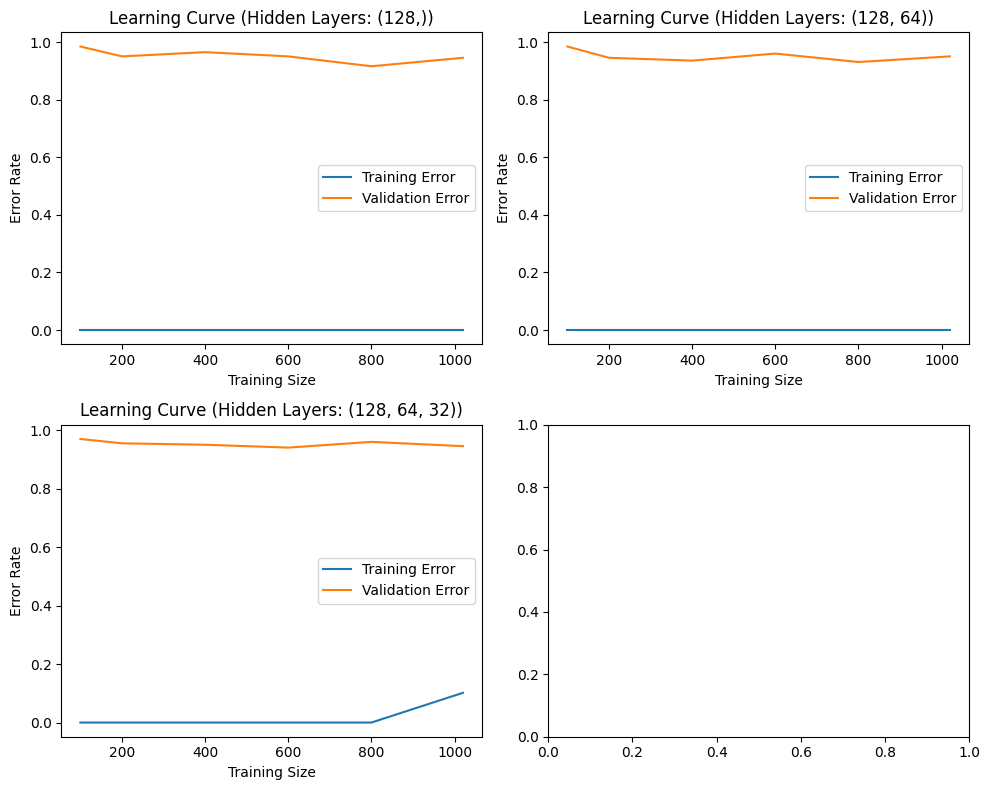

In [5]:
def plot_learning_curve_mlp(hidden_layer_sizes, x_train, y_train, x_val, y_val, train_sizes, ax=None):
    train_errors = []
    val_errors = []

    for size in train_sizes:
        x_train_subset = x_train[:size]
        y_train_subset = y_train[:size]

        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=500, alpha=1e-4, learning_rate_init=0.001, random_state=42)
        mlp.fit(x_train_subset, y_train_subset)
        
        train_pred = mlp.predict(x_train_subset)
        val_pred = mlp.predict(x_val)
        
        train_error = 1 - accuracy_score(y_train_subset, train_pred)
        val_error = 1 - accuracy_score(y_val, val_pred)
        
        train_errors.append(train_error)
        val_errors.append(val_error)
    if ax is None:
        ax = plt.gca()
    ax.plot(train_sizes, train_errors, label='Training Error')
    ax.plot(train_sizes, val_errors, label='Validation Error')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Error Rate')
    ax.set_title(f'Learning Curve (Hidden Layers: {hidden_layer_sizes})')
    ax.legend()

hidden_layer_configs = [(128,), (128, 64), (128, 64, 32)]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, config in enumerate(hidden_layer_configs):
    row = i // 2
    col = i % 2
    plot_learning_curve_mlp(config, x_train, y_train, x_val, y_val, train_sizes, ax=axes[row, col])

plt.tight_layout()
plt.savefig('flower_mlp_learning_curves_combined.png')
plt.show()

SVM

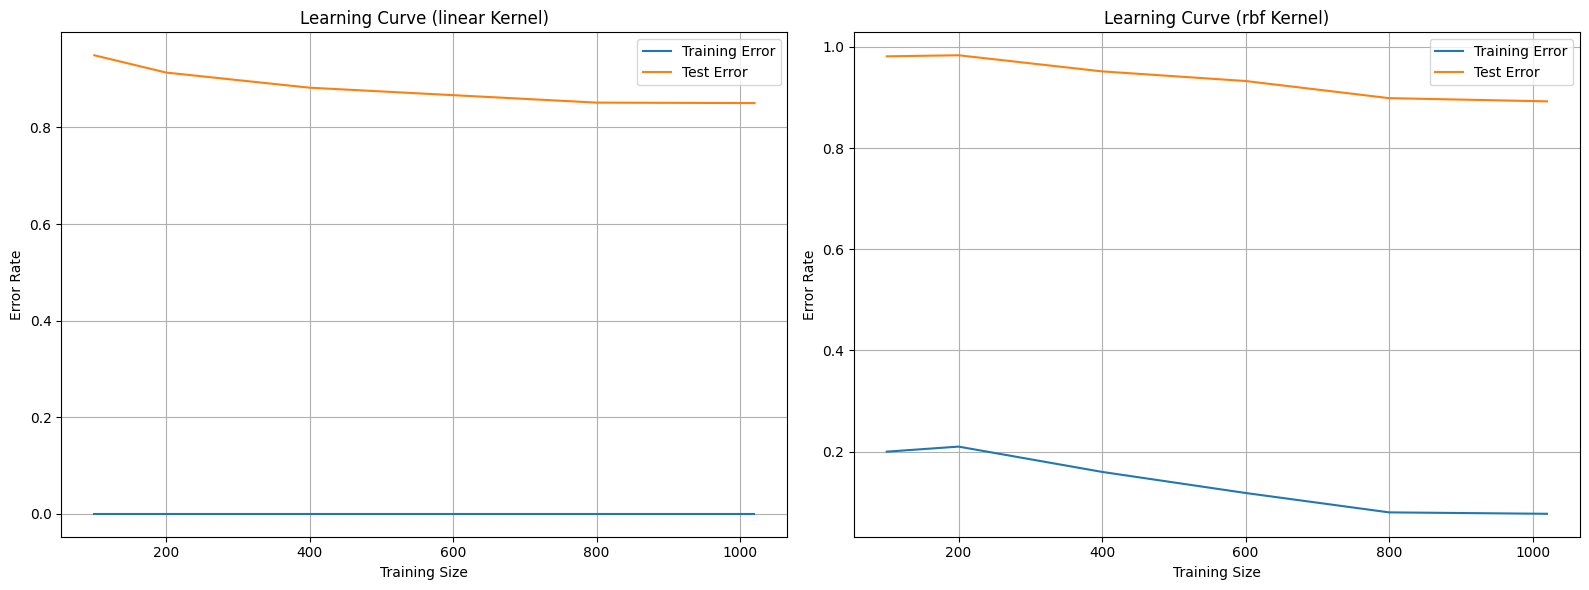

In [6]:
def plot_learning_curve(ax, kernel, x_train, y_train, x_test, y_test, train_sizes):
    train_errors = []
    test_errors = []

    for size in train_sizes:
        x_train_subset = x_train[:size]
        y_train_subset = y_train[:size]

        svm = SVC(kernel=kernel)
        svm.fit(x_train_subset, y_train_subset)
        
        train_pred = svm.predict(x_train_subset)
        test_pred = svm.predict(x_test)
        
        train_error = 1 - accuracy_score(y_train_subset, train_pred)
        test_error = 1 - accuracy_score(y_test, test_pred)
        
        train_errors.append(train_error)
        test_errors.append(test_error)

    ax.plot(train_sizes, train_errors, label='Training Error')
    ax.plot(train_sizes, test_errors, label='Test Error')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Error Rate')
    ax.set_title(f'Learning Curve ({kernel} Kernel)')
    ax.legend()
    ax.grid(True)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

plot_learning_curve(axs[0], 'linear', x_train, y_train, x_test, y_test, train_sizes)
plot_learning_curve(axs[1], 'rbf', x_train, y_train, x_test, y_test, train_sizes)

plt.tight_layout()
plt.savefig('flower_svm_learning_curves_combined.png')
plt.show()

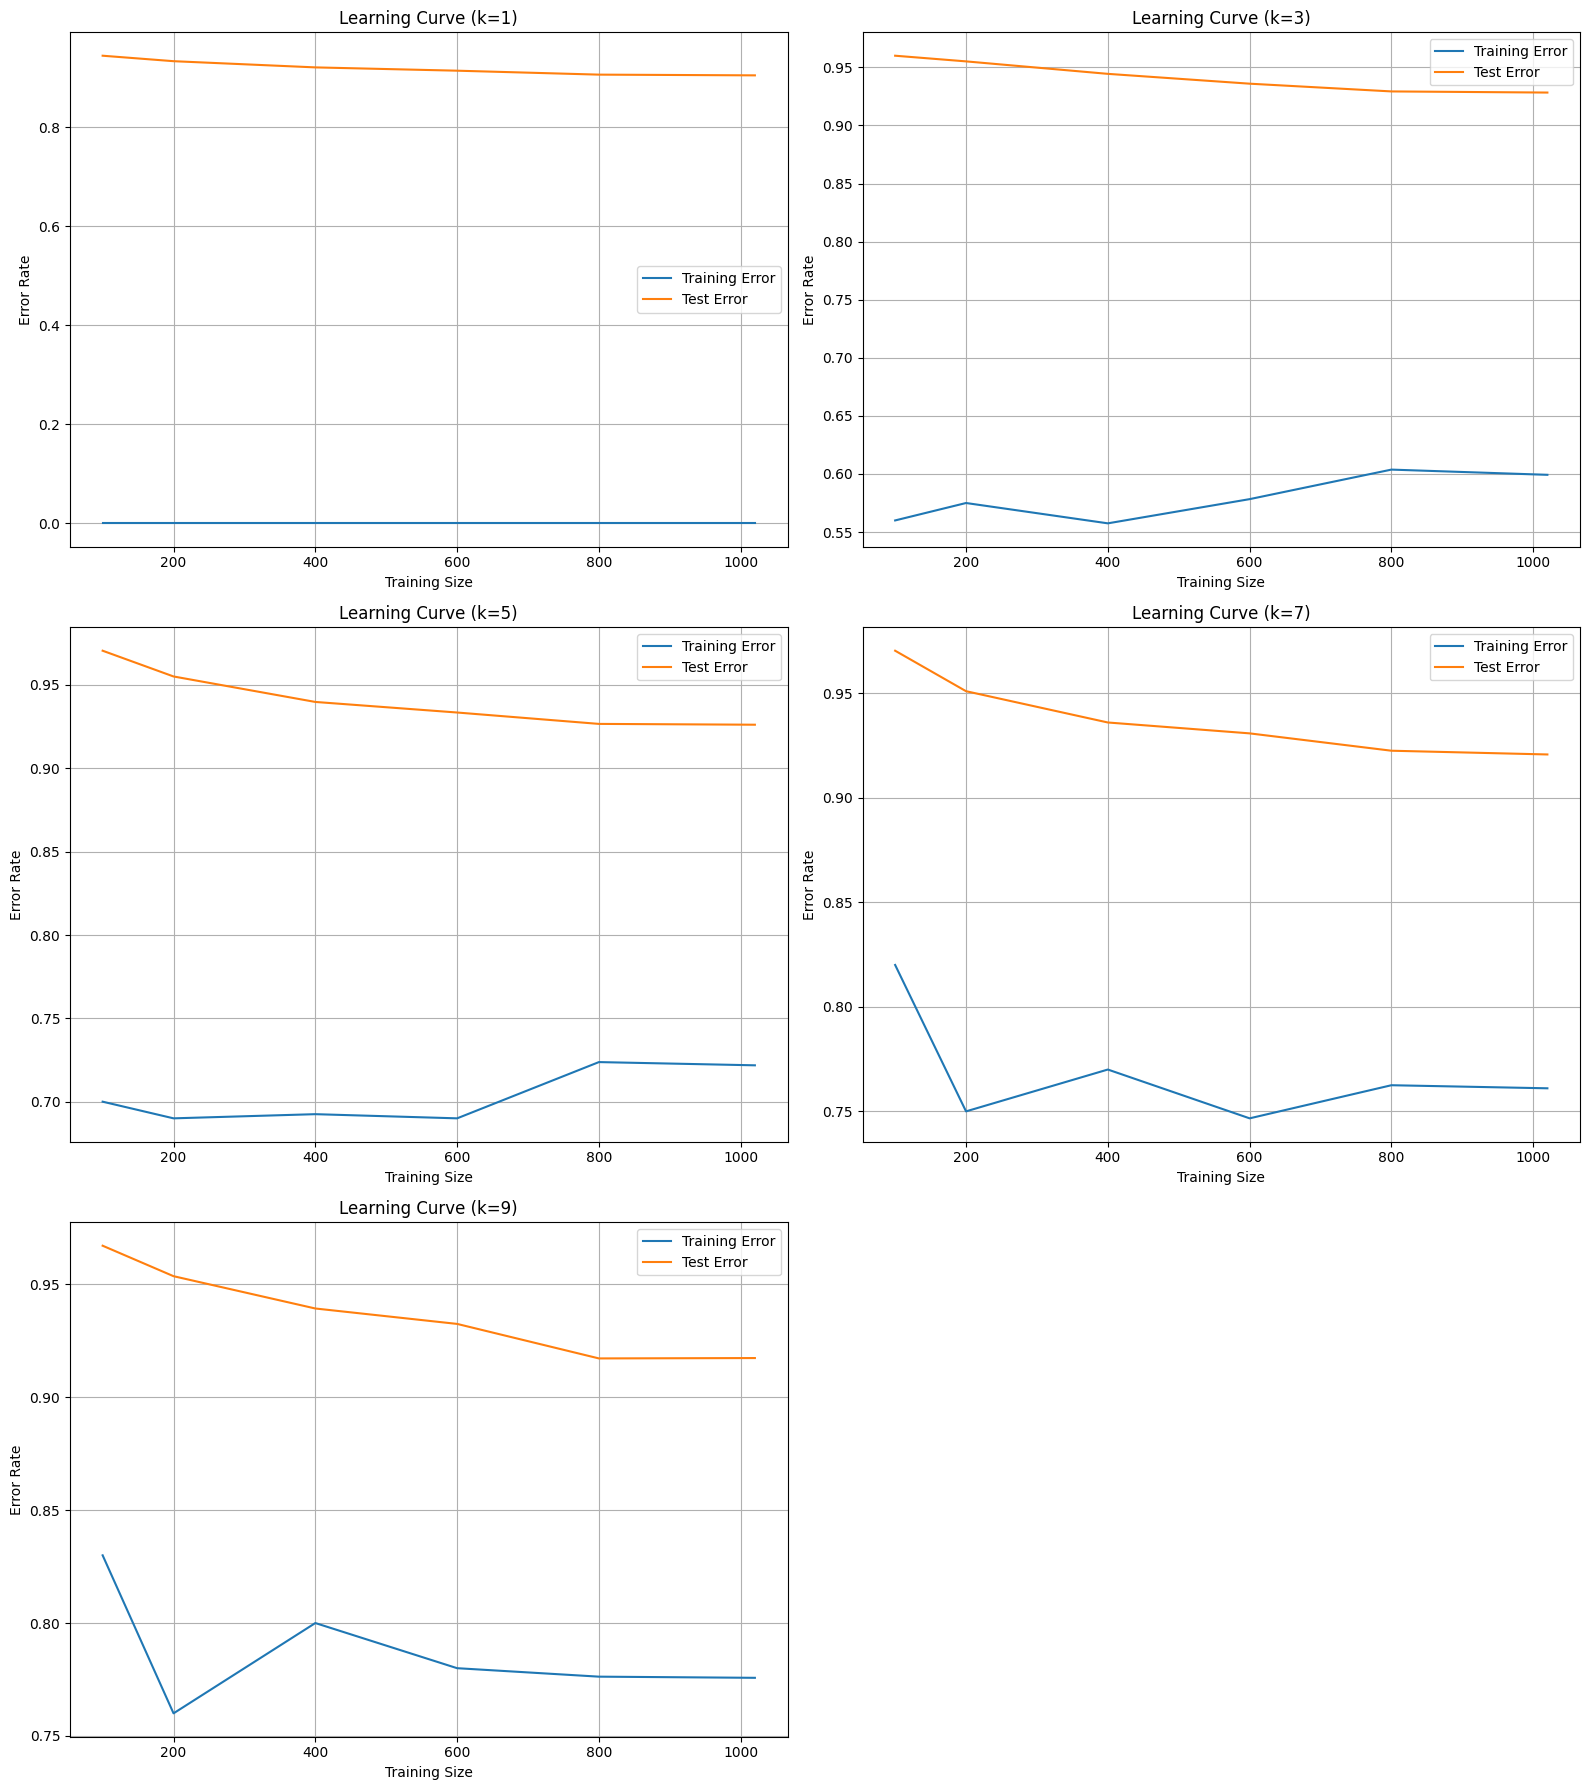

In [7]:
def plot_learning_curve_knn(ax, k, x_train, y_train, x_test, y_test, train_sizes):
    train_errors = []
    test_errors = []

    for size in train_sizes:
        x_train_subset = x_train[:size]
        y_train_subset = y_train[:size]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_subset, y_train_subset)
        
        train_pred = knn.predict(x_train_subset)
        test_pred = knn.predict(x_test)
        
        train_error = 1 - accuracy_score(y_train_subset, train_pred)
        test_error = 1 - accuracy_score(y_test, test_pred)
        
        train_errors.append(train_error)
        test_errors.append(test_error)

    ax.plot(train_sizes, train_errors, label='Training Error')
    ax.plot(train_sizes, test_errors, label='Test Error')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Error Rate')
    ax.set_title(f'Learning Curve (k={k})')
    ax.legend()
    ax.grid(True)

k_values = [1, 3, 5, 7, 9]

fig, axs = plt.subplots(3, 2, figsize=(16, 18))

for i, k in enumerate(k_values):
    row = i // 2
    col = i % 2
    plot_learning_curve_knn(axs[row, col], k, x_train, y_train, x_test, y_test, train_sizes)

if len(k_values) % 2 != 0:
    fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.savefig('flower_knn_learning_curves_combined.png')
plt.show()

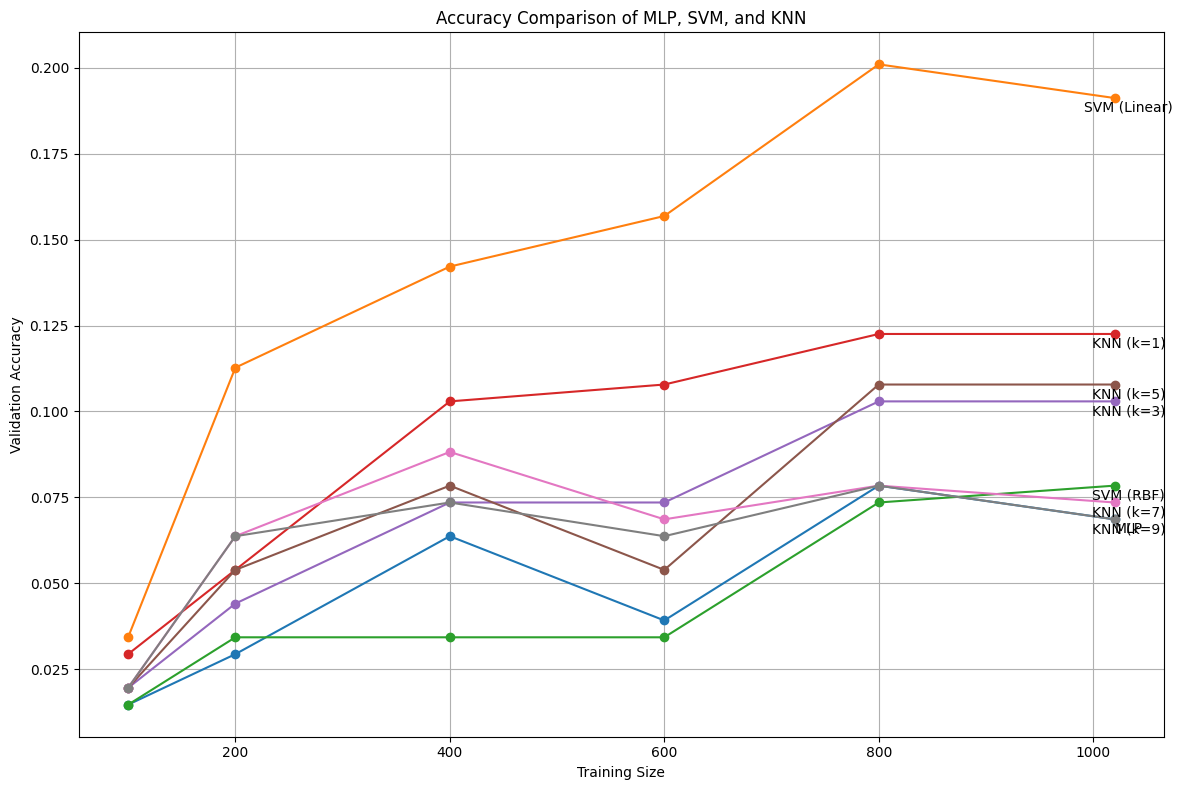

In [8]:
MLP_accuracy=-1
SVM_accuracy={'linear':-1, 'rbf':-1}
kNear_accuracy={'1':-1, '3':-1, '5':-1, '7':-1, '9':-1}
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)
def compute_accuracies(algorithm, x_train, y_train, x_val, y_val, train_sizes):
    val_accuracies = []

    for size in train_sizes:
        x_train_subset = x_train[:size]
        y_train_subset = y_train[:size]

        algorithm.fit(x_train_subset, y_train_subset.ravel())
        val_pred = algorithm.predict(x_val)
        val_accuracy = accuracy_score(y_val, val_pred)
        val_accuracies.append(val_accuracy)

    return val_accuracies
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
svm_linear = SVC(kernel='linear', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42, gamma='scale')
knn_k1 = KNeighborsClassifier(n_neighbors=1)
knn_k3 = KNeighborsClassifier(n_neighbors=3)
knn_k5 = KNeighborsClassifier(n_neighbors=5)
knn_k7 = KNeighborsClassifier(n_neighbors=7)
knn_k9 = KNeighborsClassifier(n_neighbors=9)

MLP_accuracy = compute_accuracies(mlp, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
SVM_accuracy['linear'] = compute_accuracies(svm_linear, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
SVM_accuracy['rbf'] = compute_accuracies(svm_rbf, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
kNear_accuracy['1'] = compute_accuracies(knn_k1, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
kNear_accuracy['3'] = compute_accuracies(knn_k3, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
kNear_accuracy['5'] = compute_accuracies(knn_k5, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
kNear_accuracy['7'] = compute_accuracies(knn_k7, x_train_pca, y_train, x_val_pca, y_val, train_sizes)
kNear_accuracy['9'] = compute_accuracies(knn_k9, x_train_pca, y_train, x_val_pca, y_val, train_sizes)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, MLP_accuracy, label='MLP', marker='o')
plt.annotate('MLP', (train_sizes[-1], MLP_accuracy[-1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.plot(train_sizes, SVM_accuracy['linear'], label='SVM (Linear)', marker='o')
plt.annotate('SVM (Linear)', (train_sizes[-1], SVM_accuracy['linear'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.plot(train_sizes, SVM_accuracy['rbf'], label='SVM (RBF)', marker='o')
plt.annotate('SVM (RBF)', (train_sizes[-1], SVM_accuracy['rbf'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.plot(train_sizes, kNear_accuracy['1'], label='KNN (k=1)', marker='o')
plt.annotate('KNN (k=1)', (train_sizes[-1], kNear_accuracy['1'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.plot(train_sizes, kNear_accuracy['3'], label='KNN (k=3)', marker='o')
plt.annotate('KNN (k=3)', (train_sizes[-1], kNear_accuracy['3'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.plot(train_sizes, kNear_accuracy['5'], label='KNN (k=5)', marker='o')
plt.annotate('KNN (k=5)', (train_sizes[-1], kNear_accuracy['5'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.plot(train_sizes, kNear_accuracy['7'], label='KNN (k=7)', marker='o')
plt.annotate('KNN (k=7)', (train_sizes[-1], kNear_accuracy['7'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.plot(train_sizes, kNear_accuracy['9'], label='KNN (k=9)', marker='o')
plt.annotate('KNN (k=9)', (train_sizes[-1], kNear_accuracy['9'][-1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('Training Size')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy Comparison of MLP, SVM, and KNN')
plt.grid(True)
plt.tight_layout()
plt.savefig('flower_accuracy_comparison.png')
plt.show()